In [1]:
import sys
parentdir = 'C:\\Users\\anaxa\\Documents\\Projects\\Synthetic avatar\\BAMT'
sys.path.insert(0,parentdir) 

In [2]:
import pandas as pd
import numpy as np
from bayesian.train_bn import structure_learning, parameter_learning
from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from bayesian.calculate_accuracy import calculate_acc, LOO_validation
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from preprocess.discretization import discretization, get_nodes_type, code_categories, get_nodes_sign
from visualization.visualization import draw_BN, draw_comparative_hist
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('seaborn')
import math
from bayesian.calculate_accuracy import calculate_acc
from bayesian.sampling import generate_synthetics
import networkx as nx
from scipy.spatial import distance
from sklearn.cluster import KMeans
import operator
from copy import copy
from sklearn.metrics import accuracy_score, mean_squared_error
from external.libpgm.sampleaggregator import SampleAggregator
from typing import Tuple
from dtaidistance import dtw
from sklearn.preprocessing import MinMaxScaler

In [6]:
act_names = dict()
act_names['Изготовление металоконструкций траверс act'] = 'Изготовление металлоконструкций траверс act'
act_names['Монтаж волоконно-оптического кабеля по металлоконструкциям act'] = 'Монтаж ВОК по металлоконструкциям act'
act_names['Монтаж металоконструкций траверс act'] = 'Монтаж металлоконструкций траверс act'
act_names['Монтаж муфты оптической на опоре 86/1 act'] = 'Монтаж муфты оптической на опоре act'
act_names['Монтаж муфты оптической на опоре сущ1, сущ2 act'] = 'Монтаж муфты оптической на опоре act'
act_names['Монтаж оголовков act'] = 'Монтаж оголовников свай act'
act_names['Монтаж опор (направляющие, скользящие, неподвижные) act'] = 'Монтаж опор act'
act_names['Монтаж опор (направляющие. скользящие. неподвижные) act'] = 'Монтаж опор act'
act_names['Срезка свай (под отметку) act'] = 'Срезка свай act'


In [7]:
res_names = dict()
res_names['Автобетономеситель 6*6 КАМАЗ res'] = 'Автобетоносмеситель res'
res_names['Автокран (25 тн) res'] = 'Автокран res'
res_names['Автокран КС 45721 res'] = 'Автокран res'
res_names['Автомобиль ("Нива", "Петрович") res'] = 'Автомобиль res'
res_names['Автомобиль вахтовый res'] = 'Автомобиль res'
res_names['Бетонщики res'] = 'Бетонщик res'
res_names['Бульдозер САТ Д6 res'] = 'Бульдозер res'
res_names['Бульдозер типа САТ D6 res'] = 'Бульдозер res'
res_names['Бульдозер. трактор res'] = 'Бульдозер res'
res_names['Бурильная машина БМ-811 res'] = 'Бурильная машина res'
res_names['Вахта (Камаз) res'] = 'Вахтовый автомобиль res'
res_names['Газорезчики res'] = 'Газорезчик res'
res_names['ДЭС DENYO 2х пост res'] = 'ДЭС res'
res_names['Изолировщики res'] = 'Изолировщик res'
res_names['Маляры, изолировщики res'] = 'Маляр res'
res_names['Механизаторы. водители res'] = 'Механизаторы res'
res_names['Механик-водитель res'] = 'Механик res'
res_names['Монтажники res'] = 'Монтажник res'
res_names['Разнорабочие res'] = 'Разнорабочий res'
res_names['Руководитель строительства res'] = 'Руководитель res'
res_names['Самосвал (20 тн) res'] = 'Самосвал res'
res_names['Сварочный пост/сварочный аппарат  res'] = 'Сварочный пост res'
res_names['Стропальщики res'] = 'Стропальщик res'
res_names['Трубоукладчик ТР-12.22.02 res'] = 'Трубоукладчик res'
res_names['Экскаватор  гидробур res'] = 'Экскаваторы res'
res_names['Экскаватор  ковш res'] = 'Экскаваторы res'
res_names['Экскаватор РС400 res'] = 'Экскаваторы res'
res_names['Электрик. электромонтажник res'] = 'Электромонтажник res'


In [3]:
def LOO_validation(bn:dict(), initial_data: pd.DataFrame, method: str, columns: list, search: str = 'HC', score: str = 'K2', normed: str = 'none') -> Tuple[dict, dict, list, list]:
    """Function for Leave One Out cross validation of BN

    Args:
        initial_data (pd.DataFrame): source dataset without coding and discretization.
        data_for_strucure_learning (pd.DataFrame): can be discretized or not depends on what type of structure learning you want. For K2 only discrete can be.
        method (str): method of sampling - simple or mix
        columns (list): list of params for accuracy estimation
        search (str, optional): search strategy for structural learning (HC or evo). Defaults to 'HC'.
        score (str, optional): Score function for HC structure learning. Defaults to 'K2'.
        normed (str, optional): type of rmse normalization (range, std, none). Defaults to 'none'.

    Raises:
        Exception: With K2 function you can use only discrete data for structure learning

    Returns:
        Tuple[dict, dict, list, list]: accuracy, rmse, real data, predicted data
    """   
    accuracy_dict = dict()
    rmse_dict = dict()
    node_type = get_nodes_type(initial_data)
   
    pred_param = [[0 for j in range(initial_data.shape[0])] for i in range(len(columns))]
    real_param = [[0 for j in range(initial_data.shape[0])] for i in range(len(columns))]
    for i in range (initial_data.shape[0]):
        print(i)
        test = dict(initial_data.iloc[i,:])
        param_train = initial_data.drop(index=i)
        param_train.reset_index(inplace=True, drop = True)
        params = parameter_learning(param_train, node_type, bn, method)
        save_structure(bn, 'LOO_net')
        skel = read_structure('LOO_net')
        save_params(params, 'LOO_net_param')
        params = read_params('LOO_net_param')
        all_bn = HyBayesianNetwork(skel, params)
        for n, key in enumerate(columns):
            train_dict = copy(test)
            train_dict.pop(key)
            try:
                if node_type[key] == 'disc':
                    agg = SampleAggregator()
                    sample = agg.aggregate(all_bn.randomsample(2000, method, train_dict))
                    sorted_res = sorted(sample[key].items(), key=operator.itemgetter(1), reverse=True)
                    pred_param[n][i] = sorted_res[0][0]
                    real_param[n][i] = test[key]
                if node_type[key] == 'cont':
                    sample = pd.DataFrame(all_bn.randomsample(2000, method, train_dict))
                    if (initial_data[key] >= 0).all():
                        sample = sample.loc[sample[key] >= 0]
                    if sample.shape[0] == 0:
                        pred_param[n][i] = np.nan
                        real_param[n][i] = np.nan
                    else:
                        pred = np.mean(sample[key].values)
                        pred_param[n][i] = pred
                        real_param[n][i] = test[key]
            except Exception as ex:
                print(ex)
                pred_param[n][i] = np.nan
                real_param[n][i] = np.nan
    for l in range(len(columns)):
        pred_param[l] = [element for element in pred_param[l] if str(element) != 'nan']
        real_param[l] = [element for element in real_param[l] if str(element) != 'nan']
    for n, key in enumerate(columns):
        if node_type[key] == 'disc':
            accuracy_dict[key] = round(accuracy_score(real_param[n], pred_param[n]),2)
        if node_type[key] == 'cont':
            if normed == 'range':
                rmse_dict[key] = round(mean_squared_error(real_param[n], pred_param[n], squared=False) / (np.max(real_param[n]) - np.min(real_param[n])), 3)
            elif normed == 'std':
                std = np.std(real_param[n])
                rmse_dict[key] = round(mean_squared_error(real_param[n], pred_param[n], squared=False) / std, 3)
            elif normed == 'none':
                rmse_dict[key] = round(mean_squared_error(real_param[n], pred_param[n], squared=False), 3)
    return accuracy_dict, rmse_dict, real_param, pred_param

## Формирование итоговой матрицы частот рёбер

In [341]:
df = pd.read_csv('file6_fact.csv')
#df = df.drop(columns = ['Unnamed: 0'])


In [342]:
df_empty_column = []
for c in df.columns:
    if (df[c] == 0).all():
        df_empty_column.append(c)

In [343]:
df_empty_column

['Подготовка вдоль трассового проезда act']

In [344]:
columns = [c for c in df.columns.tolist() if c not in df_empty_column]
df = df[columns]

In [345]:
df = df.astype(float)
df

,Бетонщик res,Бурение под сваи act,"ВЛ Кусты скважин №10,10.1 АС act","ВЛ Кусты скважин №10,10.1 АСЭ act",Газорезчик res,Заливка свай act,ИТР res,Механик res,Монтаж оголовников свай act,Монтаж опор act,Монтажник res,Погружение свай act,Разнорабочий res,Руководитель res,Срезка свай act,Электромонтеры линейщики res,Электросварщики res
0,7.0,5.0,15.0,0.0,1.0,15.0,2.0,3.0,20.0,20.0,5.0,15.0,7.0,1.0,15.0,14.0,3.0
1,7.0,21.0,15.0,0.0,1.0,38.0,2.0,3.0,15.0,3.0,5.0,30.0,7.0,1.0,15.0,14.0,3.0
2,7.0,0.0,15.0,0.0,1.0,0.0,2.0,3.0,11.0,16.0,5.0,0.0,7.0,1.0,11.0,14.0,3.0
3,7.0,0.0,15.0,0.0,1.0,0.0,2.0,3.0,0.0,0.0,5.0,0.0,7.0,1.0,0.0,14.0,3.0
4,7.0,0.0,15.0,0.0,1.0,0.0,2.0,3.0,2.0,0.0,5.0,0.0,7.0,1.0,0.0,14.0,3.0
5,7.0,3.0,15.0,0.0,1.0,2.0,2.0,3.0,15.0,8.0,5.0,3.0,7.0,1.0,15.0,14.0,3.0
6,7.0,5.0,7.0,0.0,1.0,6.0,2.0,3.0,22.0,0.0,5.0,5.0,7.0,1.0,17.0,14.0,3.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [346]:
node_types = get_nodes_type(df)

In [347]:
act = [c for c in df.columns if c.split()[-1]=='act']
res = [c for c in df.columns if c.split()[-1]=='res']
num_act = len(act)
num_res = len(res)
df_act = df[act]
df_res = df[res]

<AxesSubplot:>

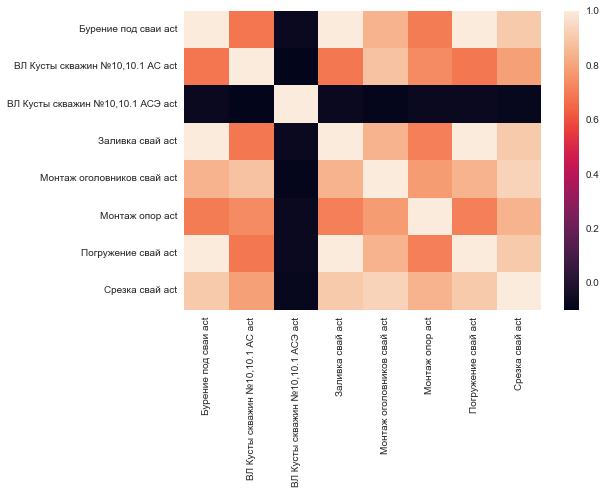

In [348]:
corr = df_act.corr('spearman')
sns.heatmap(corr)

In [349]:
corr

,Бурение под сваи act,"ВЛ Кусты скважин №10,10.1 АС act","ВЛ Кусты скважин №10,10.1 АСЭ act",Заливка свай act,Монтаж оголовников свай act,Монтаж опор act,Погружение свай act,Срезка свай act
Бурение под сваи act,1.000000,0.685817,-0.070085,0.999703,0.840136,0.697951,0.999703,0.905437
"ВЛ Кусты скважин №10,10.1 АС act",0.685817,1.000000,-0.098206,0.687278,0.883683,0.737218,0.687278,0.786062
"ВЛ Кусты скважин №10,10.1 АСЭ act",-0.070085,-0.098206,1.000000,-0.070064,-0.088796,-0.070064,-0.070064,-0.079748
Заливка свай act,0.999703,0.687278,-0.070064,1.000000,0.839384,0.707838,1.000000,0.904087
Монтаж оголовников свай act,0.840136,0.883683,-0.088796,0.839384,1.000000,0.779178,0.839384,0.927878
Монтаж опор act,0.697951,0.737218,-0.070064,0.707838,0.779178,1.000000,0.707838,0.837038
Погружение свай act,0.999703,0.687278,-0.070064,1.000000,0.839384,0.707838,1.000000,0.904087
Срезка свай act,0.905437,0.786062,-0.079748,0.904087,0.927878,0.837038,0.904087,1.000000


In [350]:
corr.fillna(0, inplace=True)

In [351]:
cosine_dist = np.empty((num_act, num_act))
for i, c1 in enumerate(act):
    for j, c2 in enumerate(act):
        cosine_dist[i, j] = distance.cosine(corr[c1].values, corr[c2].values)

In [352]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(cosine_dist)

In [353]:
corr['labels'] = kmeans.labels_

In [354]:
columns1 = corr.loc[corr['labels'] == 0].index.tolist()
columns1

['ВЛ Кусты скважин №10,10.1 АС act',
 'Монтаж оголовников свай act',
 'Монтаж опор act']

In [355]:
columns2 = corr.loc[corr['labels'] == 1].index.tolist()
columns2

['ВЛ Кусты скважин №10,10.1 АСЭ act']

In [356]:
columns3 = corr.loc[corr['labels'] == 2].index.tolist()
columns3

['Бурение под сваи act',
 'Заливка свай act',
 'Погружение свай act',
 'Срезка свай act']

In [357]:
df1 = df[columns1 + res]
df2 = df[columns2 + res]
df3 = df[columns3 + res]

In [358]:
white_list1 = []
for c1 in columns1:
    for c2 in res:
        white_list1.append((c1, c2))
        white_list1.append((c2, c1))

In [359]:
white_list2 = []
for c1 in columns2:
    for c2 in res:
        white_list2.append((c1, c2))
        white_list2.append((c2, c1))

In [360]:
white_list3 = []
for c1 in columns3:
    for c2 in res:
        white_list3.append((c1, c2))
        white_list3.append((c2, c1))

In [361]:
bn1 = structure_learning(df1, 'HC', node_types, 'K2', white_list=white_list1)

In [362]:
bn2 = structure_learning(df2, 'HC', node_types, 'K2', white_list=white_list2)

In [363]:
bn3 = structure_learning(df3, 'HC', node_types, 'K2', white_list=white_list3)

In [364]:
save_structure(bn1, 'file6_bn1')
save_structure(bn2, 'file6_bn2')
save_structure(bn3, 'file6_bn3')

In [8]:
all_acts = []
all_res = []
for i in [1,3,4,5,6]:
    df = pd.read_csv('file'+str(i)+'_fact.csv')
    for c in df.columns.tolist():
        if (c.split()[-1] == 'act') & (c not in all_acts):
            all_acts.append(c)
        if (c.split()[-1] == 'res') & (c not in all_res):
            all_res.append(c)

In [9]:
for i in range (len(all_acts)):
    if all_acts[i] in act_names.keys():
        all_acts[i] = act_names[all_acts[i]]
for i in range (len(all_res)):
    if all_res[i] in res_names.keys():
        all_res[i] = res_names[all_res[i]]

all_acts = list(dict.fromkeys(all_acts))
all_res = list(dict.fromkeys(all_res))

In [10]:
freq_edge = pd.DataFrame(data=np.zeros((len(all_acts), len(all_res))), columns=all_res)
freq_edge.index = all_acts


In [11]:
for i in [1,3,4,5,6]:
    bn1 = read_structure('file'+str(i)+'_bn1')
    bn2 = read_structure('file'+str(i)+'_bn2')
    bn3 = read_structure('file'+str(i)+'_bn3')
    for edge in bn1.E:
        if edge[0].split()[-1] == 'act':
            freq_edge.loc[edge[0], edge[1]] += 1
        else:
            freq_edge.loc[edge[1], edge[0]] += 1
    for edge in bn2.E:
        if edge[0].split()[-1] == 'act':
            freq_edge.loc[edge[0], edge[1]] += 1
        else:
            freq_edge.loc[edge[1], edge[0]] += 1
    for edge in bn3.E:
        if edge[0].split()[-1] == 'act':
            freq_edge.loc[edge[0], edge[1]] += 1
        else:
            freq_edge.loc[edge[1], edge[0]] += 1
        

C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8960 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8960 missing from current font.
  font.set_text(s, 0, flags=flags)


<AxesSubplot:>

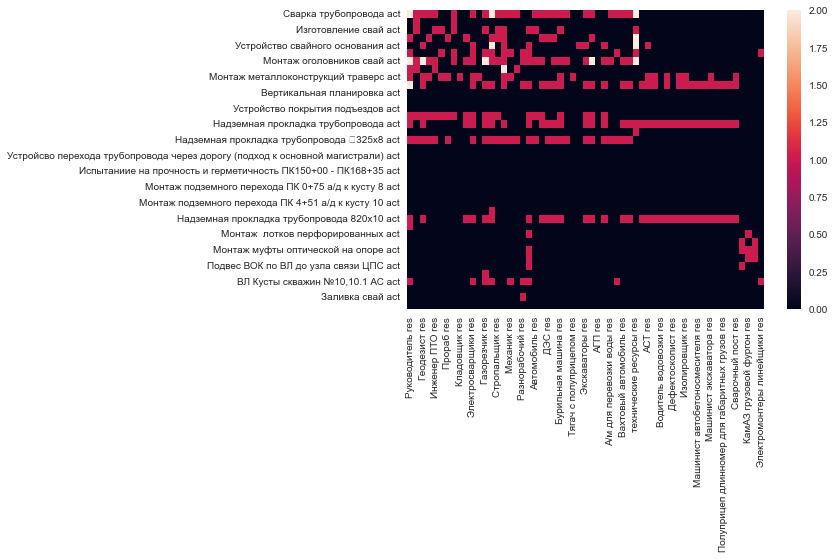

In [12]:
sns.heatmap(freq_edge)

In [13]:
empty_res = []
empty_act = []
for c in freq_edge.columns.tolist():
    if (freq_edge[c] == 0).all():
        empty_res.append(c)
for c in freq_edge.index.tolist():
    if (freq_edge.loc[c,:] == 0).all():
        empty_act.append(c)


In [372]:
empty_res

['АГП res']

In [373]:
empty_act

['Вертикальная планировка act',
 'Устройство подъезда act',
 'Устройство покрытия подъездов act',
 'Надземная прокладка трубопровода ⌀426х9 act',
 'Устройсво перехода трубопровода через дорогу (подход к основной магистрали) act',
 'Устройсво перехода трубопровода через дорогу на К-3.1 act',
 'Испытаниие на прочность и герметичность ПК150+00 - ПК168+35 act',
 'Монтаж надземного перехода ПР1 act',
 'Монтаж подземного перехода ПК 0+75 а/д к кусту 8 act',
 'Монтаж подземного перехода ПК 36+86 Ш26,Ш27,Ш37 act',
 'Монтаж подземного перехода ПК 4+51 а/д к кусту 10 act',
 'ВЛ Кусты скважин №10,10.1 АСЭ act',
 'Подготовка вдоль трассового проезда act']

## Построение сетей по файлам на основе матрицы частот

In [14]:
df = pd.read_csv('file3_fact.csv')
#df = df.drop(columns = ['Unnamed: 0'])
df = df.astype(float)

In [15]:
df_empty_column = []
for c in df.columns:
    if (df[c] == 0).all():
        df_empty_column.append(c)


columns = [c for c in df.columns.tolist() if c not in df_empty_column]
df = df[columns]

In [16]:
act = [c for c in df.columns if c.split()[-1]=='act']
res = [c for c in df.columns if c.split()[-1]=='res']

In [17]:
act

['Бурение скважин act',
 'Изготовление металлоконструкций траверс act',
 'Изготовление свай act',
 'Монтаж металлоконструкций траверс act',
 'Монтаж оголовников свай act',
 'Монтаж опор act',
 'Надземная прокладка трубопровода act',
 'Надземная прокладка трубопровода ⌀159х6 act',
 'Надземная прокладка трубопровода ⌀325х8 act',
 'Надземная прокладка трубопровода ⌀426х9 act',
 'Сварка трубопровода act',
 'Срезка свай act',
 'Устройство свайного основания act']

In [31]:
bn = dict()
bn['V'] = df.columns.tolist()
bn['E'] = []
for c2 in res:
    #parents = 0
    for c1 in act:
        if (freq_edge.loc[c1, c2] > 0): #& (parents < 4):
            bn['E'].append([c1, c2])
            #parents += 1

In [401]:
act_i = act[1]
colors_res = []
for r in res:
    c = 'b'
    for e in bn['E']:
        if (e[0] == act_i) & (e[1] == r):
            c = 'r'
            break
    colors_res.append(c)
colors_act = []
for c in act:
    if c == act_i:
        colors_act.append('r')
    else:
        colors_act.append('b')


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

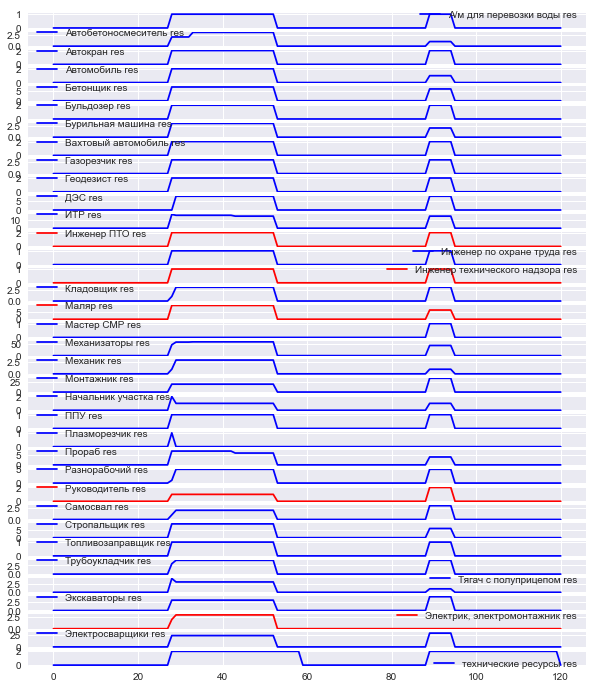

In [402]:
df[res].plot(subplots=True, style = colors_res, figsize=(10,12))

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8960 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8960 missing from current font.
  font.set_text(s, 0, flags=flags)


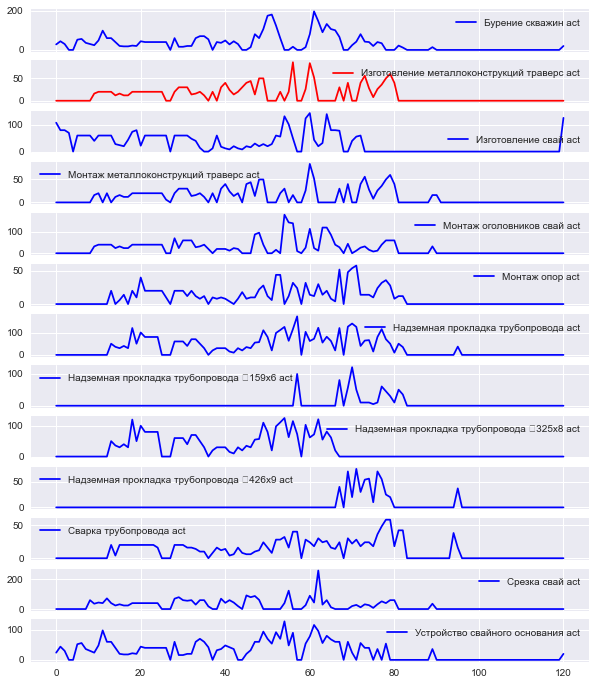

In [403]:
df[act].plot(subplots=True, style = colors_act, figsize=(10,12))

In [19]:
node_types = get_nodes_type(df)
node_sign = get_nodes_sign(df)

In [404]:
for c in act:
    bn_act = dict()
    nodes = [c]
    edges = []
    for e in bn['E']:
        if e[0] == c:
            edges.append(e)
            nodes.append(e[1])
    bn_act['V'] = nodes
    bn_act['E'] = edges
    draw_BN(bn_act, node_types,'smal_bn '+str(c))

In [20]:

params = parameter_learning(df, node_types, bn, 'mix')

In [21]:
save_structure(bn, 'file3_structure')
skel = read_structure('file3_structure')
save_params(params, 'file3_param')
params = read_params('file3_param')
bn = HyBayesianNetwork(skel, params)

In [22]:
sample = generate_synthetics(bn, node_sign, 'mix', 150)

C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Кладовщик res', ylabel='Density'>

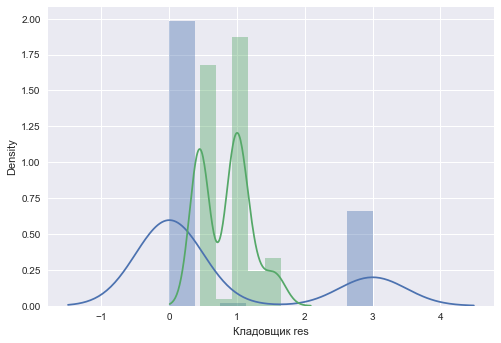

In [28]:
ind=15
sns.distplot(df[res[ind]])
sns.distplot(sample[res[ind]])

In [32]:
acc, rmse, real, pred = LOO_validation(bn, df,'mix', res)

0


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


1
2
3
4
5
6


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)
C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


7
8
9
10
11
12


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


13


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


14


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


15
16
17
18


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


19
20
21
22


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


23
24


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)
C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


25


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)
C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)
C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


26
27


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


28


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


29
30
31
32
33


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)
C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)
C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


34
35


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


36
37
38


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


39
40
41
42


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


43
44
45
46
47


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


48


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


49
50


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


51
52


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


53
54
55


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


56
57


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)
C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


58


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


59


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


60


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


61
62
63
64
65


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)
C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


66
67
68


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


69
70
71
72


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)
C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


73
74
75
76


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


77
78
79


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)
C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)
C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


80
81


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


82


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)
C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


83
84
85
86
87


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


88
89


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


90


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


91
92
93
94
95
96


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


97
98
99
100
101
102
103


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)
C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


104
105
106
107
108


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


109
110


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)
C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


111
112
113


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)
C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


114


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


115


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)
C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)
C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


116


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


117
118


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)
C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


119


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


120


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


In [33]:
rmse

{'А/м для перевозки воды res': 0.425,
 'Автобетоносмеситель res': 1.312,
 'Автокран res': 0.91,
 'Автомобиль res': 0.795,
 'Бетонщик res': 3.176,
 'Бульдозер res': 1.105,
 'Бурильная машина res': 1.275,
 'Вахтовый автомобиль res': 0.903,
 'Газорезчик res': 1.505,
 'Геодезист res': 0.901,
 'ДЭС res': 4.118,
 'ИТР res': 12.889,
 'Инженер ПТО res': 0.961,
 'Инженер по охране труда res': 0.477,
 'Инженер технического надзора res': 0.439,
 'Кладовщик res': 1.324,
 'Маляр res': 3.996,
 'Мастер СМР res': 0.409,
 'Механизаторы res': 29.038,
 'Механик res': 1.1,
 'Монтажник res': 18.142,
 'Начальник участка res': 0.494,
 'ППУ res': 0.453,
 'Плазморезчик res': 0.328,
 'Прораб res': 2.749,
 'Разнорабочий res': 2.58,
 'Руководитель res': 0.837,
 'Самосвал res': 1.705,
 'Стропальщик res': 3.759,
 'Топливозаправщик res': 0.52,
 'Трубоукладчик res': 1.845,
 'Тягач с полуприцепом res': 1.547,
 'Экскаваторы res': 1.759,
 'Электрик, электромонтажник res': 2.319,
 'Электросварщики res': 11.91,
 'техничес

In [ ]:
bn_part = dict()
bn_part['V'] = []
bn_part['E'] = []
for e in bn.E:
    if e[0] == act[5]:
        bn_part['E'].append(e)
        if e[0] not in bn_part['V']:
            bn_part['V'].append(e[0])
        if e[1] not in bn_part['V']:
            bn_part['V'].append(e[1])
        





In [ ]:
draw_BN(bn_part, node_types, 'file3_part5')

In [ ]:
rmse, real, pred = calculate_acc_res(bn, df_param, res, 'simple')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120


In [ ]:
rmse

{'А/м для перевозки воды res': 0.091,
 'Автобетоносмеситель res': 0.273,
 'Автокран res': 0.182,
 'Автомобиль res': 0.182,
 'Бетонщик res': 0.545,
 'Бульдозер res': 0.257,
 'Бурильная машина res': 0.273,
 'Вахтовый автомобиль res': 0.182,
 'Газорезчик res': 0.182,
 'Геодезист res': 0.273,
 'ДЭС res': 1.029,
 'ИТР res': 2.443,
 'Инженер ПТО res': 0.273,
 'Инженер по охране труда res': 0.091,
 'Инженер технического надзора res': 0.091,
 'Кладовщик res': 0.091,
 'Маляр res': 1.091,
 'Механизаторы res': 3.636,
 'Механик res': 0.091,
 'Монтажник res': 8.1,
 'Начальник участка res': 0.257,
 'ППУ res': 0.182,
 'Прораб res': 0.9,
 'Разнорабочий res': 0.273,
 'Руководитель res': 0.364,
 'Самосвал res': 0.182,
 'Стропальщик res': 0.771,
 'Топливозаправщик res': 0.091,
 'Трубоукладчик res': 0.455,
 'Тягач с полуприцепом res': 0.273,
 'Экскаваторы res': 0.455,
 'Электросварщики res': 5.727}

In [412]:
additional_edges = []
for e1 in res:
    for e2 in res:
        if e1 != e2:
            additional_edges.append((e1, e2))
            additional_edges.append((e2, e1))

In [413]:
init_edges = []
for e in bn.E:
    init_edges.append((e[0], e[1]))
    
    

In [ ]:
bn_res = structure_learning(df[res], 'HC', node_types, 'K2')

In [ ]:
bn_new = dict()
bn_new['V'] = df.columns.tolist()
bn_new['E'] = bn.E + bn_res['E']

In [ ]:
bn_new = structure_learning(df, 'HC', node_types, 'K2', white_list=additional_edges, init_edges=init_edges, remove_init_edges=False)

In [ ]:
draw_BN(bn_new, node_types, 'bn_new_file3')

In [ ]:
params = parameter_learning(df_param, node_types, bn_new, 'simple')
save_structure(bn_new, 'file3_structure')
skel = read_structure('file3_structure')
save_params(params, 'file3_param')
params = read_params('file3_param')
bn = HyBayesianNetwork(skel, params)


In [ ]:
sample = generate_synthetics(bn, dict(), 'simple', 65)

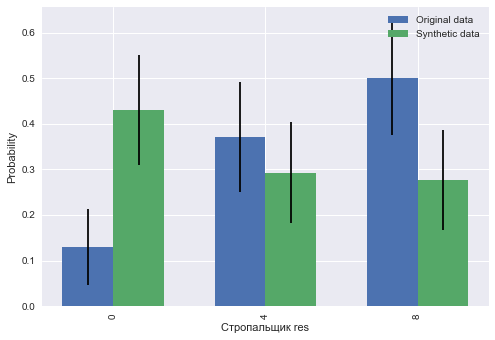

In [ ]:
draw_comparative_hist('Стропальщик res', df_param, sample, node_types)

In [ ]:
rmse, real, pred = calculate_acc_res(bn, df_param, res, 'simple')

In [ ]:
rmse

{'А/м для перевозки воды res': 0.0,
 'Автобетоносмеситель res': 0.0,
 'Автокран res': 0.0,
 'Автомобиль res': 0.0,
 'Бетонщик res': 0.0,
 'Бульдозер res': 0.0,
 'Бурильная машина res': 0.0,
 'Вахтовый автомобиль res': 0.0,
 'Газорезчик res': 0.0,
 'Геодезист res': 0.0,
 'ДЭС res': 0.0,
 'ИТР res': 0.0,
 'Инженер ПТО res': 0.0,
 'Инженер по охране труда res': 0.0,
 'Инженер технического надзора res': 0.0,
 'Кладовщик res': 0.0,
 'Маляр res': 0.0,
 'Механизаторы res': 0.0,
 'Механик res': 0.0,
 'Монтажник res': 0.0,
 'Начальник участка res': 0.0,
 'ППУ res': 0.0,
 'Прораб res': 0.0,
 'Разнорабочий res': 0.0,
 'Руководитель res': 0.0,
 'Самосвал res': 0.0,
 'Стропальщик res': 0.0,
 'Топливозаправщик res': 0.0,
 'Трубоукладчик res': 0.0,
 'Тягач с полуприцепом res': 0.0,
 'Экскаваторы res': 0.0,
 'Электросварщики res': 5.727}

## Использование N ближайших ресурсов

In [7]:
def get_n_nearest_by_corr(data, columns, number_res=5):
    groups = []
    for c in columns:
        close_ind = data[c].sort_values(ascending=False).index
        close_res = []
        for element in close_ind:
            if element.split()[-1] == 'res':
                close_res.append(element)
        groups.append([c]+close_res[0:number_res])
    return groups


def get_n_nearest_by_dist(data, columns, number_res=5):
    groups = []
    for c in columns:
        close_ind = data[c].sort_values().index
        close_res = []
        for element in close_ind:
            if element.split()[-1] == 'res':
                close_res.append(element)
        groups.append([c]+close_res[0:number_res])
    return groups


In [8]:
df = pd.read_csv('file3_fact.csv')
#df = df.drop(columns = ['Unnamed: 0'])


In [9]:
df = df.astype(float)
df

,А/м для перевозки воды res,Автобетоносмеситель res,Автокран res,Автомобиль res,Бетонщик res,Бульдозер res,Бурение скважин act,Бурильная машина res,Вахтовый автомобиль res,Газорезчик res,...,Топливозаправщик res,Трубоукладчик res,Тягач с полуприцепом res,Устройсво перехода трубопровода через дорогу (подход к основной магистрали) act,Устройсво перехода трубопровода через дорогу на К-3.1 act,Устройство свайного основания act,Экскаваторы res,"Электрик, электромонтажник res",Электросварщики res,технические ресурсы res
0,0.0,0.0,0.0,0.0,0.0,0.0,28.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,44.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,44.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
119,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


In [10]:

df_empty_column = []
for c in df.columns:
    if (df[c] == 0).all():
        df_empty_column.append(c)


columns = [c for c in df.columns.tolist() if c not in df_empty_column]
df = df[columns]

In [11]:
act = [c for c in df.columns if c.split()[-1]=='act']
res = [c for c in df.columns if c.split()[-1]=='res']

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8960 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8960 missing from current font.
  font.set_text(s, 0, flags=flags)


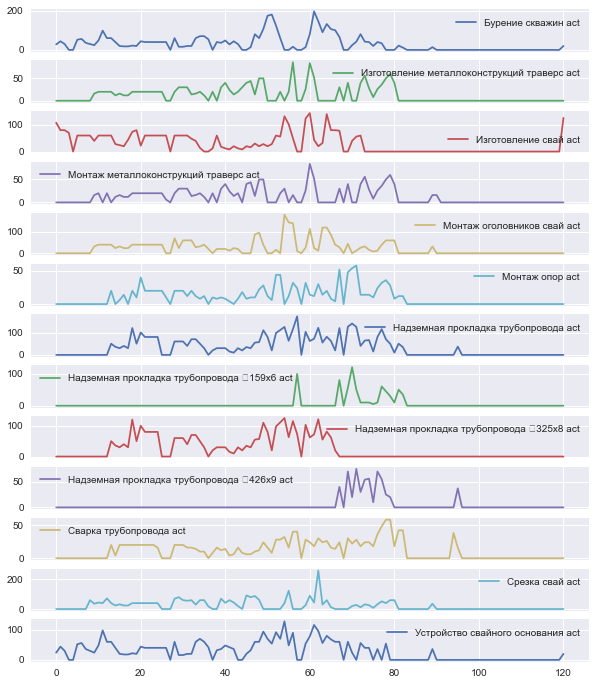

In [ ]:
df[act].plot(subplots=True, figsize=(10,12))

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

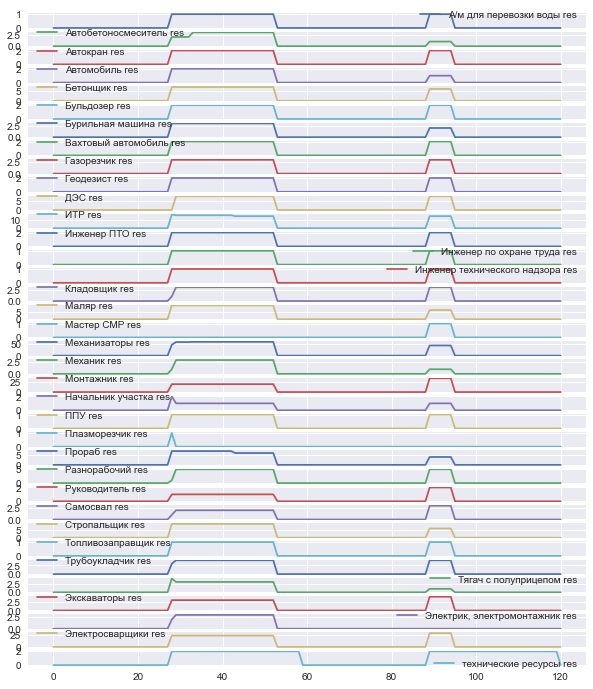

In [ ]:
df[res].plot(subplots=True, figsize=(10,12))

C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8960 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8960 missing from current font.
  font.set_text(s, 0, flags=flags)


<AxesSubplot:>

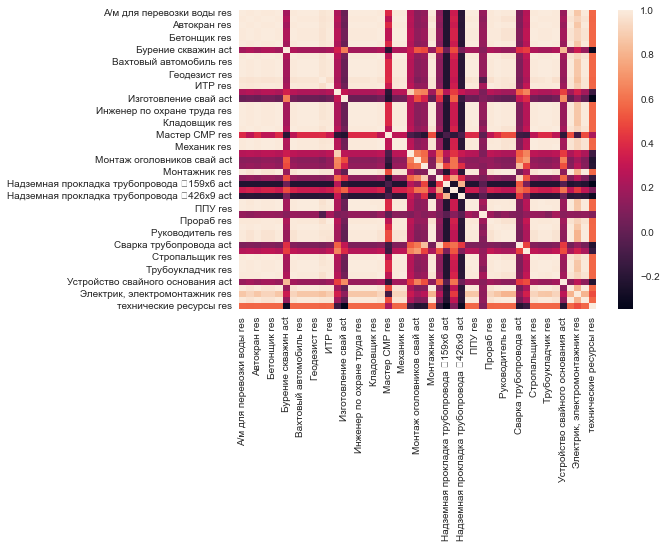

In [ ]:
sns.heatmap(df.corr(method='spearman'))

In [44]:
same_time_res = dict()
for c1 in act:
    print(c1)
    close_res = []
    for c2 in res:
        same_non_zero = 0
        max_length = 0
        start_index = 0
        flag = False
        for i in range(df.shape[0]):
            if (df.loc[i,c1] !=0) & (df.loc[i,c2] != 0):
                same_non_zero += 1    
        for i in range(1, df.shape[0]):
            if (df.loc[i,c1] !=0) & (df.loc[i,c2] != 0):
                flag = True
                if (df.loc[i-1,c1] ==0) | (df.loc[i-1,c2] == 0):
                    start_index = i
            if ((df.loc[i,c1] ==0) | (df.loc[i,c2] == 0)) & flag:
                current_lenth = (i - start_index) 
                if current_lenth >= max_length:
                    max_length = current_lenth
                flag = False
        

        print(c2 + ' ' + str(max_length))
        
        # if same_non_zero >= 20:
        #     close_res.append(c2)
    print('---------------------------') 
    same_time_res[c1] = close_res



Бурение скважин act
А/м для перевозки воды res 9
Автобетоносмеситель res 9
Автокран res 9
Автомобиль res 9
Бетонщик res 9
Бульдозер res 9
Бурильная машина res 9
Вахтовый автомобиль res 9
Газорезчик res 9
Геодезист res 9
ДЭС res 8
ИТР res 9
Инженер ПТО res 9
Инженер по охране труда res 9
Инженер технического надзора res 9
Кладовщик res 9
Маляр res 9
Мастер СМР res 1
Механизаторы res 9
Механик res 9
Монтажник res 9
Начальник участка res 9
ППУ res 9
Плазморезчик res 1
Прораб res 9
Разнорабочий res 9
Руководитель res 9
Самосвал res 9
Стропальщик res 9
Топливозаправщик res 9
Трубоукладчик res 9
Тягач с полуприцепом res 9
Экскаваторы res 9
Электрик, электромонтажник res 9
Электросварщики res 9
технические ресурсы res 9
---------------------------
Изготовление металлоконструкций траверс act
А/м для перевозки воды res 11
Автобетоносмеситель res 11
Автокран res 11
Автомобиль res 11
Бетонщик res 11
Бульдозер res 11
Бурильная машина res 11
Вахтовый автомобиль res 11
Газорезчик res 11
Геодезист re

In [45]:
brave_act_res = pd.DataFrame(data=np.zeros((len(res), len(act))), columns=act)
brave_act_res.index = res

In [46]:
for c1 in act:
    act_seq = []
    for j in df.index.tolist():
        if df.loc[j,c1] != 0:
            act_seq.append(1)
        else:
            act_seq.append(0)
    for c2 in res:
        res_seq = []
        for i in df.index.tolist():
            if df.loc[i,c2] != 0:
                res_seq.append(1)
            else:
                res_seq.append(0)
        a = 0
        b = 0
        c = 0
        d = 0
        for e1, e2 in zip(act_seq, res_seq):
            if (e1 != 0) & (e2 != 0):
                a += 1
            if (e1 != 0) & (e2 == 0):
                b += 1
            if (e1 == 0) & (e2 != 0):
                c += 1
            if (e1 == 0) & (e2 == 0):
                d += 1
        br = (a*len(act_seq) + (a+c)*(a+b)) / ((math.sqrt((a + c + 0.00000001)*(b+d + 0.00000001))) * (math.sqrt((a+b + 0.00000001)*(c+d + 0.00000001))))
        brave_act_res.loc[c2,c1] = br

In [49]:
groups = get_n_nearest_by_corr(brave_act_res, act, number_res=15)
groups

[['Бурение скважин act',
  'технические ресурсы res',
  'Автобетоносмеситель res',
  'Электросварщики res',
  'Экскаваторы res',
  'Тягач с полуприцепом res',
  'Трубоукладчик res',
  'Топливозаправщик res',
  'Стропальщик res',
  'Самосвал res',
  'Руководитель res',
  'Разнорабочий res',
  'Прораб res',
  'ППУ res',
  'Начальник участка res',
  'Монтажник res'],
 ['Изготовление металлоконструкций траверс act',
  'технические ресурсы res',
  'Автобетоносмеситель res',
  'Электросварщики res',
  'Экскаваторы res',
  'Тягач с полуприцепом res',
  'Трубоукладчик res',
  'Топливозаправщик res',
  'Стропальщик res',
  'Самосвал res',
  'Руководитель res',
  'Разнорабочий res',
  'Прораб res',
  'ППУ res',
  'Начальник участка res',
  'Монтажник res'],
 ['Изготовление свай act',
  'технические ресурсы res',
  'Автобетоносмеситель res',
  'Электросварщики res',
  'Экскаваторы res',
  'Тягач с полуприцепом res',
  'Трубоукладчик res',
  'Топливозаправщик res',
  'Стропальщик res',
  'Самосвал

In [55]:
corr = df.corr('spearman')

In [56]:
corr.fillna(0, inplace=True)

In [57]:
node_types = get_nodes_type(df)
node_sign = get_nodes_sign(df)

In [ ]:
white_list = []
for c1 in act:
    for c2 in res:
        white_list.append((c1, c2))
for c1 in res:
    for c2 in res:
        if (c1 != c2):
            white_list.append((c1, c2))
            white_list.append((c2, c1))


In [ ]:
bn = structure_learning(df, 'HC', node_types, 'K2', white_list=white_list)

In [ ]:
params = parameter_learning(df, node_types, bn, 'mix')

In [ ]:
save_structure(bn, 'file_structure')
skel = read_structure('file_structure')
save_params(params, 'file_param')
params = read_params('file_param')
bn = HyBayesianNetwork(skel, params)

In [ ]:
sample = generate_synthetics(bn, node_sign, 'mix', 120)

C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Механизаторы res', ylabel='Density'>

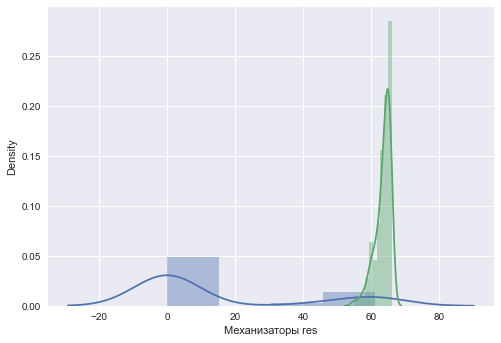

In [ ]:
n = 18
sns.distplot(df[res[n]])
sns.distplot(sample[res[n]])

In [ ]:
acc, rmse, real, pred = LOO_validation(bn, df, 'mix', res)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120


In [ ]:
rmse

{'А/м для перевозки воды res': 0.0,
 'Автобетоносмеситель res': 0.353,
 'Автокран res': 0.0,
 'Автомобиль res': 0.273,
 'Бетонщик res': 0.199,
 'Бульдозер res': 0.0,
 'Бурильная машина res': 0.242,
 'Вахтовый автомобиль res': 0.186,
 'Газорезчик res': 0.0,
 'Геодезист res': 0.0,
 'ДЭС res': 1.065,
 'ИТР res': 1.184,
 'Инженер ПТО res': 0.0,
 'Инженер по охране труда res': 0.0,
 'Инженер технического надзора res': 0.0,
 'Кладовщик res': 0.464,
 'Маляр res': 0.704,
 'Мастер СМР res': 0.102,
 'Механизаторы res': 4.52,
 'Механик res': 0.501,
 'Монтажник res': 2.327,
 'Начальник участка res': 0.463,
 'ППУ res': 0.0,
 'Плазморезчик res': 0.118,
 'Прораб res': 0.461,
 'Разнорабочий res': 0.301,
 'Руководитель res': 0.167,
 'Самосвал res': 0.378,
 'Стропальщик res': 0.776,
 'Топливозаправщик res': 0.0,
 'Трубоукладчик res': 0.465,
 'Тягач с полуприцепом res': 0.459,
 'Экскаваторы res': 0.266,
 'Электрик, электромонтажник res': 0.552,
 'Электросварщики res': 3.232,
 'технические ресурсы res': 0

In [98]:
groups = get_n_nearest_by_corr(corr, act, number_res=7)

In [99]:
groups

[['Бурение скважин act',
  'Электрик, электромонтажник res',
  'Автобетоносмеситель res',
  'Механизаторы res',
  'Тягач с полуприцепом res',
  'Маляр res',
  'Бурильная машина res',
  'Автомобиль res'],
 ['Изготовление металлоконструкций траверс act',
  'Электрик, электромонтажник res',
  'Тягач с полуприцепом res',
  'Бетонщик res',
  'Бурильная машина res',
  'Маляр res',
  'Стропальщик res',
  'Автомобиль res'],
 ['Изготовление свай act',
  'Электрик, электромонтажник res',
  'Плазморезчик res',
  'Тягач с полуприцепом res',
  'Прораб res',
  'Автомобиль res',
  'Стропальщик res',
  'Маляр res'],
 ['Монтаж металлоконструкций траверс act',
  'Электрик, электромонтажник res',
  'Прораб res',
  'Тягач с полуприцепом res',
  'Стропальщик res',
  'Бетонщик res',
  'Бурильная машина res',
  'Автомобиль res'],
 ['Монтаж оголовников свай act',
  'Электрик, электромонтажник res',
  'Прораб res',
  'ИТР res',
  'Тягач с полуприцепом res',
  'Плазморезчик res',
  'Автомобиль res',
  'Бетонщик

In [50]:
df_normed = pd.DataFrame(data = MinMaxScaler().fit_transform(df.values), columns=df.columns)
df_normed

,А/м для перевозки воды res,Автобетоносмеситель res,Автокран res,Автомобиль res,Бетонщик res,Бульдозер res,Бурение скважин act,Бурильная машина res,Вахтовый автомобиль res,Газорезчик res,...,Срезка свай act,Стропальщик res,Топливозаправщик res,Трубоукладчик res,Тягач с полуприцепом res,Устройство свайного основания act,Экскаваторы res,"Электрик, электромонтажник res",Электросварщики res,технические ресурсы res
0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.187500,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.224490,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.343750,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.153061,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.234375,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0
117,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0
118,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0
119,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0


In [87]:
distance_df = pd.DataFrame(data=np.zeros((len(res), len(act))), columns=act)
distance_df.index = res

In [88]:
for c1 in act:
    non_emty_act_ind = []
    for i in df.index:
        if df.loc[i,c1] != 0:
            non_emty_act_ind.append(i)
    for c2 in res:
        distance_df.loc[c2, c1] = distance.euclidean(df_normed.loc[:, c1].values, df_normed.loc[:, c2].values)


In [89]:
groups = get_n_nearest_by_dist(distance_df, act, 7)

In [90]:
groups

[['Бурение скважин act',
  'Плазморезчик res',
  'Начальник участка res',
  'Тягач с полуприцепом res',
  'Руководитель res',
  'Мастер СМР res',
  'Монтажник res',
  'Самосвал res'],
 ['Изготовление металлоконструкций траверс act',
  'Плазморезчик res',
  'Начальник участка res',
  'Тягач с полуприцепом res',
  'Руководитель res',
  'Мастер СМР res',
  'Монтажник res',
  'Самосвал res'],
 ['Изготовление свай act',
  'Плазморезчик res',
  'Начальник участка res',
  'Мастер СМР res',
  'Тягач с полуприцепом res',
  'Руководитель res',
  'Монтажник res',
  'Самосвал res'],
 ['Монтаж металлоконструкций траверс act',
  'Плазморезчик res',
  'Начальник участка res',
  'Мастер СМР res',
  'Тягач с полуприцепом res',
  'Руководитель res',
  'Монтажник res',
  'Самосвал res'],
 ['Монтаж оголовников свай act',
  'Плазморезчик res',
  'Начальник участка res',
  'Мастер СМР res',
  'Руководитель res',
  'Тягач с полуприцепом res',
  'Монтажник res',
  'Самосвал res'],
 ['Монтаж опор act',
  'Плаз

In [150]:
bn = dict()
bn['V'] = df.columns.tolist()
bn['E'] = []
for g in groups:
    for i in range(1, len(g)):
        bn['E'].append([g[0], g[i]])

In [151]:
white_list = []
for c1 in res:
    for c2 in res:
        if c1 != c2:
            white_list.append((c1,c2))
            white_list.append((c2, c1))

In [152]:
bn_res = structure_learning(df, 'HC', node_types, 'K2', white_list = white_list)

In [153]:
bn['E'] = bn['E'] + bn_res['E']

In [140]:
params = parameter_learning(df, node_types, bn, 'mix')

In [141]:
save_structure(bn, 'file_structure')
skel = read_structure('file_structure')
save_params(params, 'file_param')
params = read_params('file_param')
bn = HyBayesianNetwork(skel, params)

In [142]:
sample = generate_synthetics(bn, node_sign, 'mix', 120)

C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Маляр res', ylabel='Density'>

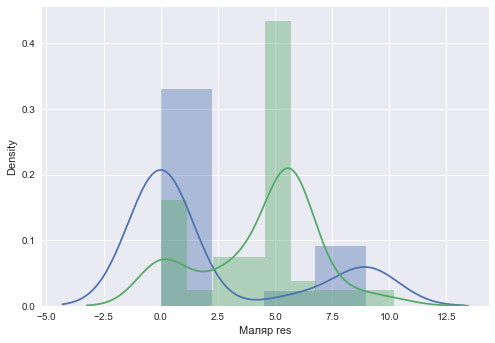

In [148]:
n = 16
sns.distplot(df[res[n]])
sns.distplot(sample[res[n]])

In [154]:
acc, rmse, real, pred = LOO_validation(bn, df, 'mix', res)

0
1
2
3
4


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)
C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


5
6
7
8
9
10
11
12


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


13
14
15
16
17
18
19
20
21
22
23
24
25


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


26
27
28
29


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


30


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


31
32


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


33
34
35
36


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


37
38
39
40


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


41


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


42
43


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


44
45
46
47
48
49
50
51


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


52
53
54
55
56
57
58
59
60
61


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


62


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


63
64
65
66
67
68
69
70
71
72


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


73
74
75


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


76
77
78


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


79


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


80


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


81
82


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


83
84
85
86
87


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


88
89
90
91


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


92


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


93
94
95


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


96


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


97
98
99
100


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)
C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


101
102
103
104
105
106
107


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


108
109
110
111
112
113


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


114
115
116
117
118


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


119
120


In [155]:
rmse

{'А/м для перевозки воды res': 0.0,
 'Автобетоносмеситель res': 0.262,
 'Автокран res': 0.0,
 'Автомобиль res': 0.07,
 'Бетонщик res': 1.502,
 'Бульдозер res': 0.0,
 'Бурильная машина res': 0.757,
 'Вахтовый автомобиль res': 0.0,
 'Газорезчик res': 0.0,
 'Геодезист res': 0.0,
 'ДЭС res': 0.005,
 'ИТР res': 0.673,
 'Инженер ПТО res': 0.146,
 'Инженер по охране труда res': 0.0,
 'Инженер технического надзора res': 0.0,
 'Кладовщик res': 0.036,
 'Маляр res': 0.0,
 'Мастер СМР res': 0.855,
 'Механизаторы res': 5.081,
 'Механик res': 0.226,
 'Монтажник res': 3.208,
 'Начальник участка res': 0.164,
 'ППУ res': 0.0,
 'Плазморезчик res': 0.1,
 'Прораб res': 0.479,
 'Разнорабочий res': 2.38,
 'Руководитель res': 0.171,
 'Самосвал res': 0.213,
 'Стропальщик res': 0.428,
 'Топливозаправщик res': 0.0,
 'Трубоукладчик res': 0.2,
 'Тягач с полуприцепом res': 1.56,
 'Экскаваторы res': 0.38,
 'Электрик, электромонтажник res': 1.373,
 'Электросварщики res': 1.569,
 'технические ресурсы res': 0.93}

In [ ]:
net = groups[0]
start_dag = []
white_list = []
for v1 in net:
    for v2 in net:
        if (v1.split()[-1] == 'act') & (v2.split()[-1] == 'res') & (v1!=v2):
            start_dag.append((v1, v2))
        if (v1.split()[-1] == 'res') & (v2.split()[-1] == 'res') & (v1!=v2):
            white_list.append((v1, v2))



In [ ]:
bn = structure_learning(df[net], 'HC', node_types, 'K2', white_list = white_list, init_edges=start_dag, remove_init_edges=False)

In [ ]:
draw_BN(bn, node_types, 'file3')

In [ ]:
params = parameter_learning(df[net], node_types, bn, 'mix')

In [ ]:
save_structure(bn, 'file_structure')
skel = read_structure('file_structure')
save_params(params, 'file_param')
params = read_params('file_param')
bn = HyBayesianNetwork(skel, params)

In [ ]:
# sample = generate_synthetics(bn, node_sign, 'mix', 130)
sample = pd.DataFrame(columns=sample.columns)
for val in df[net[0]].values:
    temp_sample = generate_synthetics(bn, node_sign, 'mix', 1, {net[0]: val})
    sample = pd.concat([sample, temp_sample])

In [ ]:
sample

,Бурение скважин act,Механизаторы res,Тягач с полуприцепом res,"Электрик, электромонтажник res",Автобетоносмеситель res,Бурильная машина res,Маляр res,Автомобиль res
0,56.0,17.237797,3.000000,3.000000,0.847761,0.847761,2.543282,0.565174
0,98.0,21.223180,3.000000,3.000000,1.043763,1.043763,3.131289,0.695842
0,60.0,48.000000,4.000000,2.146359,2.105930,2.824715,8.474792,1.883287
0,60.0,48.000000,4.000000,2.146359,2.105930,2.824715,8.474792,1.883287
0,20.0,9.818959,3.000000,3.000000,0.482900,0.482900,1.448699,0.321933
0,22.0,10.318334,3.000000,3.000000,0.507459,0.507459,1.522377,0.338306
0,20.0,9.818959,3.000000,3.000000,0.482900,0.482900,1.448699,0.321933
0,60.0,48.000000,4.000000,2.146359,2.105930,2.824715,8.474792,1.883287
0,20.0,9.818959,3.000000,3.000000,0.482900,0.482900,1.448699,0.321933
0,20.0,9.818959,3.000000,3.000000,0.482900,0.482900,1.448699,0.321933


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Электрик, электромонтажник res', ylabel='Density'>

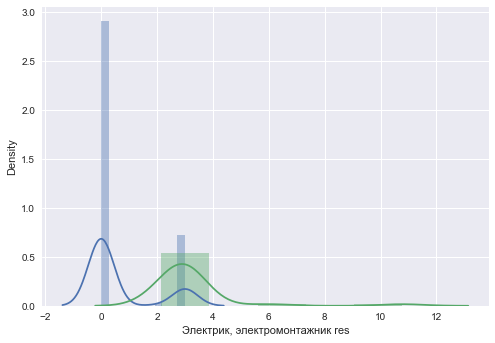

In [ ]:
sns.distplot(df[net[1]])
sns.distplot(sample[net[1]])

C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Автобетоносмеситель res', ylabel='Density'>

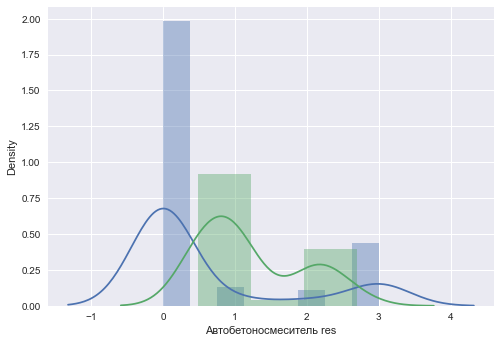

In [ ]:
sns.distplot(df[net[2]])
sns.distplot(sample[net[2]])

C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Механизаторы res', ylabel='Density'>

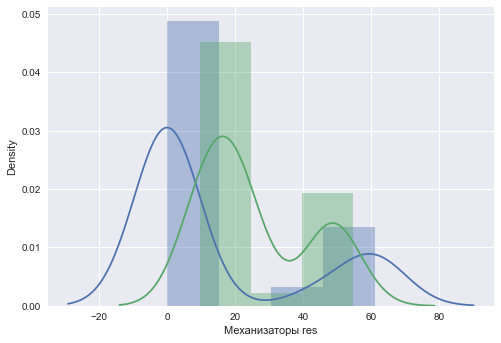

In [ ]:
sns.distplot(df[net[3]])
sns.distplot(sample[net[3]])

C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Тягач с полуприцепом res', ylabel='Density'>

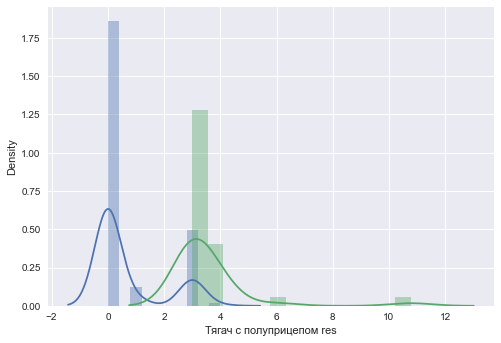

In [ ]:
sns.distplot(df[net[4]])
sns.distplot(sample[net[4]])

C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Маляр res', ylabel='Density'>

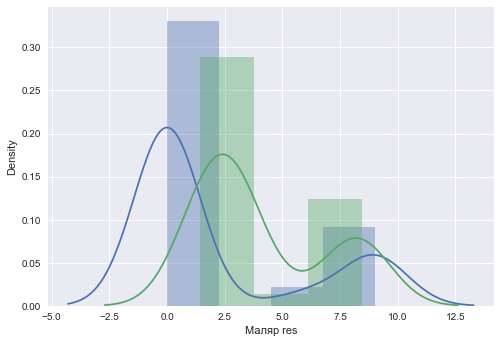

In [ ]:
sns.distplot(df[net[5]])
sns.distplot(sample[net[5]])

C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Бурильная машина res', ylabel='Density'>

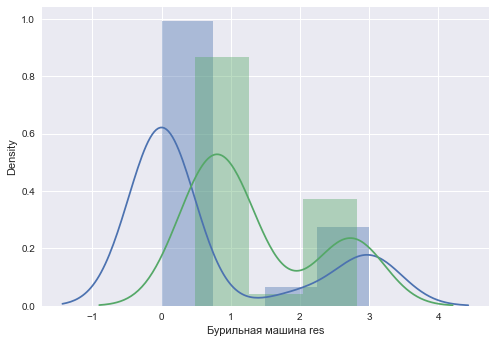

In [ ]:
sns.distplot(df[net[6]])
sns.distplot(sample[net[6]])

In [ ]:
acc, rmse, real, pred = LOO_validation(df[net], df[net].astype(int), 'mix', net[1:len(net)])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


39
40
41
42
43


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120


In [ ]:
rmse

{'Электрик, электромонтажник res': 1.262,
 'Автобетоносмеситель res': 0.388,
 'Механизаторы res': 8.275,
 'Тягач с полуприцепом res': 0.28,
 'Маляр res': 0.57,
 'Бурильная машина res': 0.155,
 'Автомобиль res': 0.08}